# TODOs

## Techinical
- Try use plain BERT Rob
- RAG Paolo
- shakespear
- Checkpoints for outcome prediction

## Chores
- Setting up model on hugging face
- How to use the dataset from hugging face
- How to use the mdoel from hugging face
- Clean the github repo
- Make a question list
- Make a usable pip package from the repo
- write a README

# Group Assignment NLP course 2024/2025

## Group: NLP Processors
* Ginefra Paolo
* Onori Ferdinando
* Missana Martina
* Uhrich Robin

##  Dataset: [Strategic Game Chess](https://huggingface.co/datasets/laion/strategic_game_chess)

The dataset used contains data on chess games generated through self-play **Stockfish** engine using **Fugaku** (a supercomputer in Kobe, Japan) adding initial moves to expand the diversity. It contains **3.2 billion games** with approximately 608 billion moves.

Due to computational constraints we decided to work just on the first parquet file of the dataset, containing the first **100.000 games**. 

Each game in the dataset is composed of three columns:
* **Move**: a sequence of all the moves made during the game.

* **Termination**: the condition under which the game ended. Possible values include: 
    - `CHECKMATE`
    - `INSUFFICIENT MATERIAL`
    - `FIVEFOLD_REPETITION`
    - `SEVENTYFIVE_MOVES`
    - `STALEMATE`
* **Result**: result of the game
    - `1-0`         (White wins)
    - `1/2-1/2`     (Draw)
    - `0-1`         (Black wins)

 #### **Data Wrangling**

To facilitate the use of the dataset and ensure all necessary information is available for the project, a set of Parquet files was created with the following structure:
* **Moves**

* **Termination**

* **Result**

* **Pieces**: the piece moved in every move

* **Captures**: the type of piece captured (if any) at each move.

* **Checks**: a boolean value indicating whether a move resulted in a check (`true` or `false`)

* **Next_move**: the move sequence shifted by one position, useful for predictive modeling tasks

* **Result_seqs**: a repeated sequence of the final result, aligned with the length of the move sequence for each game


In addition, two YAML files were created to support data processing:

- **Move Lookup Table**  

  A mapping of all possible moves to unique integer identifiers.

- **Result Lookup Table**  

  A mapping of game results (`1-0`, `0-1`, `1/2-1/2`) to numerical labels, useful for classification tasks.


All the files used were uploaded on **Hugging Face**

#### TODOs:
* explaining why we used just one parquet file
* creation of the dataset
* our goal for the project (how much chess lang is a natural lang)
* disclaimer that we stick the dataset as closely as possible with assumingnot  having knowledge ofunderlyingmodelof chess

### 1. Preliminary Analysis

#### TODOs:
* Data Exploration (type of data, structure, vocaboulary, ...) - verbose stuff
* graph - verbose stuff
* Zipf's Law
* usage of move visualizer/ move plotter
* clustering (Australia  plot) (Paolo explaining if  clusters make sens)
* word2vec and embeddings (Paolo)
* move distribution(martina)
* FEN distribution (Ferdinando)
* skipgrams n-grams(matrices, dendrograms(?))

Termination and Result distribution globally and showed by gamelenght
For the first move distribution there's few variability

We try FEN as boardState describer, we were interest in it as we were looking if there were any convergences state among the match consideration regard [games_ID,FEN].unique
plot with the overallFEN, we cut of the first 43 moves as we identified them as opening trough the the Zipf's exponent; most of the most common FEN were in the first moves after the 42th, it also visible the majority oif the most frequent fen happening in match wich end up in a tie

#### Data Exploration

This section will breafly explorer the data and reason on how stockfish play

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

#df = pd.read_parquet("data\chess_game_0001.parquet")
df = pd.read_parquet("data/chess_game_0001.parquet")
df = df.iloc[:100_000]
df.head()

Text(0.5, 1.0, 'Result')

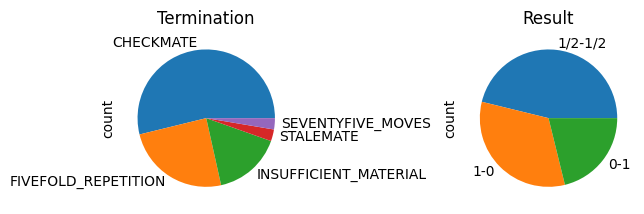

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
df["Termination"].value_counts().plot.pie(ax=ax1)
df["Result"].value_counts().plot.pie(ax=ax2)
fig.tight_layout()

ax1.set_title("Termination")
ax2.set_title("Result")

By rules all the termination not CHECKMATE lead to draw; within the CHECKMATE the distribution is around around 30% for "1-0" and around 20% for "0-1"
For human chess this distribution is usually with less tie and the other two result are a bit more balanced but always with more "1-0"

Text(0, 0.5, 'Number of Games')

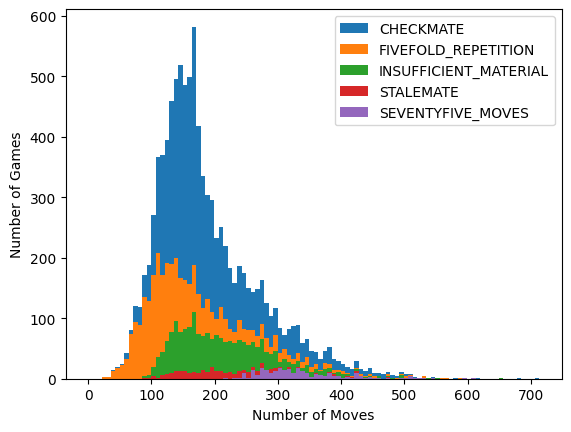

In [16]:
lengths = df.copy()
lengths["Moves"] = df["Moves"].apply(lambda x: len(x)) 

fig, ax = plt.subplots()            

bins = np.linspace(0, max(lengths["Moves"]), 100 + 1)
bin_width = bins[1]
counts = []
labels = []
n_labels = len(lengths["Termination"].unique())
bar_width = bin_width / n_labels
for idx, (label, group) in enumerate(lengths.groupby("Termination")):
    count, _ = np.histogram(group["Moves"], bins=bins)
    counts.append(count)
    labels.append(label)                    
    #   ax.bar(bins[:-1] + bar_width / 2 + idx * bar_width, count, bar_width)
counts = np.stack(counts)
sort_idx = np.argsort(counts.sum(axis=1))
counts = counts[sort_idx]
labels = np.array(labels)[sort_idx]

for count, label in zip(counts.cumsum(axis=0)[::-1], labels[::-1]):
    ax.bar(bins[:-1] + bin_width / 2, count, width=bin_width, label=label)
    
ax.legend()
ax.set_xlabel("Number of Moves")
ax.set_ylabel("Number of Games")

Already the peak of the distribution is over the mean number of moves in a human chess game
Probably during the match if not major error are commited by one of the two bot and then punished by the other in the phase were there're more strategy possibilities, otherwise the model playing nearly perfectly end up in the different type of stall which lead to a tie

We have a brief look at the pawn promotion/capture distribution
In the UCI format:

    k: king

    q: queen

    r: rook

    b: bishop

    n: knight

    p: pawn
    

In [12]:
start_pos = np.zeros((8, 8), dtype=int)
end_pos = np.zeros((8, 8), dtype=int)
captured_pieces = []
pieces = "kqbnrp"
capture_pos = np.zeros((len(pieces), 8, 8), dtype=int)
for move in tqdm(np.concat(df["Moves"].values)):
    start_pos[ord(move[0]) - ord("a"), int(move[1]) - 1] += 1
    end_pos[ord(move[2]) - ord("a"), int(move[3]) - 1] += 1
        
    if len(move) == 5:
        captured_pieces.append(move[4])
        capture_pos[pieces.find(move[4]), ord(move[2]) - ord("a"), int(move[3]) - 1] += 1

100%|██████████| 1894261/1894261 [00:02<00:00, 841680.17it/s]


<Axes: >

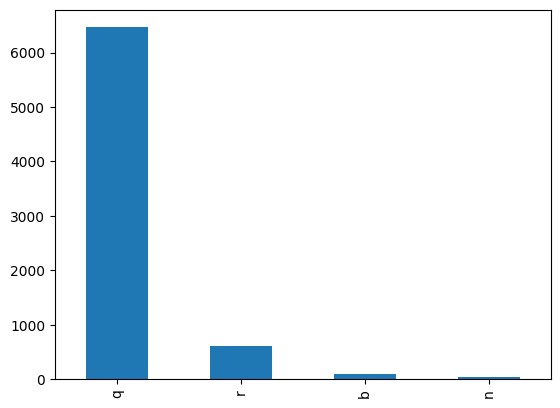

In [ ]:
pd.Series(captured_pieces).value_counts().plot.bar()        

As expected the queen is largely the most promoted piece, pleasing some chess metrics as the queen is the piece with highest value, nonetheless it is also probabibly considered the most relevant strategic piece by Stockfish

In [14]:
start_pos = np.zeros((8, 8), dtype=int)
end_pos = np.zeros((8, 8), dtype=int)
captured_pieces = []
pieces = "kqbnrp"
capture_pos = np.zeros((len(pieces), 8, 8), dtype=int)
for move in tqdm(df["Moves"]):
    move = move[0]
    start_pos[ord(move[0]) - ord("a"), int(move[1]) - 1] += 1
    end_pos[ord(move[2]) - ord("a"), int(move[3]) - 1] += 1
        
    if len(move) == 5:
        captured_pieces.append(move[4])
        capture_pos[pieces.find(move[4]), ord(move[2]) - ord("a"), int(move[3]) - 1] += 1

100%|██████████| 10001/10001 [00:00<00:00, 595021.55it/s]


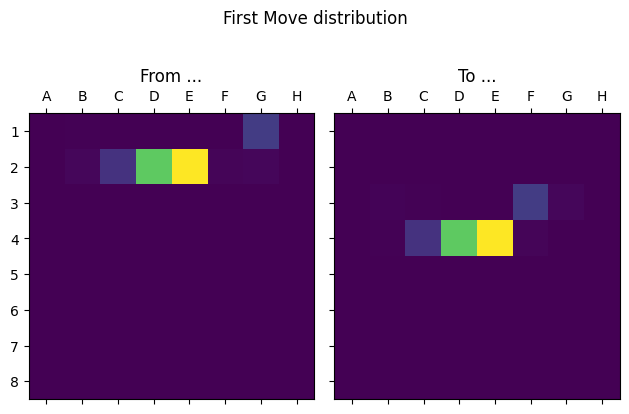

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.matshow(start_pos.T)
ax2.matshow(end_pos.T)

fig.suptitle("First Move distribution")
ax1.set_title("From ...")   
ax2.set_title("To ...")

ax1.set_yticks(np.arange(8), np.arange(8) + 1)
ax1.set_xticks(np.arange(8), ["A", "B", "C", "D", "E", "F", "G", "H"])
ax2.set_xticks(np.arange(8), ["A", "B", "C", "D", "E", "F", "G", "H"])
fig.tight_layout()

The additional initial moves where very few or were all standard opening in chess;
many opening start with e2e4 and the same is true for d2d4 while the other 2 moves here are indeed the start of other precise opening: c2c4 for the English Opening and g1f3 for the Réti Opening

#### Zipf's Law
We would like to understand if the sequence of moves in chess could be identified as Natural Language

$f(r) = \frac{C}{r^s}$

where f(r) is the frequency of the word at rank r, C is a constant, and s is the Zipf exponent.

The Zipf's exponent is useful for analysis since:
- s<1: The distribution flattens. Frequencies are more evenly spread across ranks, indicating a more uniform distribution of items.
- s=1: The classic Zipfian case. The second-ranked item occurs half as frequently as the first, and so on. This implies that a few words are extremely common, and many are rare.
- s>1: The distribution is steeper.
    High-ranked items dominate, and lower-ranked items become significantly rare. 
    This suggests a system where a few elements are overwhelmingly prevalent.



In [21]:
import chess
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
from collections import Counter
import seaborn as sns
sns.set_theme()

conn = sqlite3.connect("C:/Users/ferdi/Desktop/UNI/NLP/chess_games.db")
cursor = conn.cursor()

In [22]:
df = pd.read_sql_query("SELECT game_id, move FROM moves", conn)
# group by game_id 
len_games = df.groupby('game_id').size()
#drop column game_ids from the dataframe
#remove the last character if the move has five characters to exclude differences in promotions
df['move'] = df['move'].str[:-1].where(df['move'].str.len() == 5, df['move'])

# Count the occurrences of each move
move_counts = Counter(df['move'].tolist())

# Sort the moves by frequency
sorted_move_counts = move_counts.most_common()
move_ranks = range(1, len(sorted_move_counts) + 1)
move_frequencies = [count for fen, count in sorted_move_counts]

log_move_ranks = np.log(move_ranks)
log_move_freqs = np.log(move_frequencies)
move_coeffs = np.polyfit(log_move_ranks, log_move_freqs, 1)
move_slope = move_coeffs[0]
print(f"Estimated Zipf exponent for moves: {abs(move_slope):.2f}")

Estimated Zipf exponent for moves: 0.90


In [24]:
import os
# load  all the writings from shakespeare
path = "C:/Users/ferdi/Downloads/shakespearWritings/shakespearWritings"
doc = ""
for filename in os.listdir(path):
    if filename.endswith(".txt"):
        with open(os.path.join(path, filename), "r") as file:
            doc += file.read() + " "

shakespearWritings = doc.split()

word_counts = Counter(shakespearWritings)
# Sort the words by frequency
sorted_word_counts = word_counts.most_common()
word_ranks = range(1, len(sorted_word_counts) + 1)
word_frequencies = [count for word, count in sorted_word_counts]

log_word_ranks = np.log(word_ranks)
log_word_freqs = np.log(word_frequencies)
word_coeffs = np.polyfit(log_word_ranks, log_word_freqs, 1)
word_slope = word_coeffs[0]

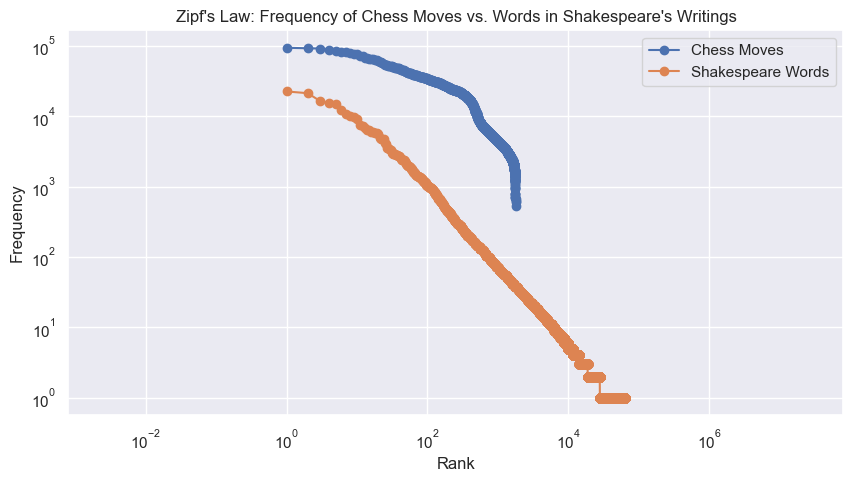

Estimated Zipf exponent for moves: 0.90
Estimated Zipf exponent in Shakespear's writings: 1.09


In [25]:
#Compare on the same plot the chess plot and the Shakespear one
plt.figure(figsize=(10, 5))
plt.loglog(move_ranks, move_frequencies, marker='o', label="Chess Moves")
plt.loglog(word_ranks, word_frequencies, marker='o', label="Shakespeare Words")
plt.title("Zipf's Law: Frequency of Chess Moves vs. Words in Shakespeare's Writings")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.legend()
plt.axis('equal')
plt.show()

print(f"Estimated Zipf exponent for moves: {abs(move_slope):.2f}")
print(f"Estimated Zipf exponent in Shakespear's writings: {abs(word_slope):.2f}")

The two exponent are quite similar this could be sign of being a Natural Language but the big nonlinearity could be causing a bias in che exponent computation

### 2. Training Models

#### TODOs:
* LAMA
* LSTM
* RAG (Paolo)
* Transformer (plots)
* Zeroshot-multishot(?)(Ferdinando)


### 3. Possible Extensions

#### TODOs:
* chessbots with game entropy etc. (lstm,ferdinando,voice)

(menu and intuition)

### 4. Conclusions (?)

* adding knowledge should result in better performances...
* computationalconstraintsssss
* chess grammar